In [19]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr
from sklearn.metrics import mutual_info_score
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch.nn as nn
import torch
from torch_geometric.data import Data
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import seaborn as sns
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from tigramite.toymodels import structural_causal_processes


# Underlying SCM

In [6]:
# {
# 0: x_1 [], 
# 1: x_2 [((0, 0), coeff, lin_f), ((5, 0), coeff, lin_f)], 
# 2: M   [((1, 0), coeff, lin_f), ((5, 0), coeff, lin_f)],
# 3: Y   [((1, 0), coeff, lin_f), ((2, 0), coeff, lin_f), ((6, 0), coeff, lin_f), ((7, 0), coeff, lin_f)],
# 4: Z_1 [((5, 0), coeff, lin_f), ((7, 0), coeff, lin_f)], 
# 5: Z_2 [], 
# 6: Z_3 [],
# 7: [],
# }

# Loading data

In [7]:
df = pd.read_pickle('intervention_data2.pkl')
# df = pd.read_pickle('lin_df.pkl')
df.head(3)

,x0,x1,x2,x3,x4,x5,x6,x7
0,0.0,0.0,0.248834,-0.087867,-1.288305,-1.123094,0.973667,NaN
1,0.0,0.0,0.929797,-0.160463,1.274541,0.237258,-0.501115,NaN
2,0.0,0.0,-1.187943,0.356178,-0.912174,-1.018844,0.055279,NaN


# GNN

In [23]:



def lin_f(x): return x

# Step 1: Generate the data
coeff = 0.5
links_coeffs = {
    0: [],
    1: [((0, 0), coeff, lin_f), ((5, 0), coeff, lin_f)],
    2: [((1, 0), coeff, lin_f), ((5, 0), coeff, lin_f)],
    3: [((1, 0), coeff, lin_f), ((2, 0), coeff, lin_f), ((6, 0), coeff, lin_f), ((7, 0), coeff, lin_f)],
    4: [((5, 0), coeff, lin_f), ((7, 0), coeff, lin_f)],
    5: [],
    6: [],
    7: [],
}
T = 10000
data_array, nonstat = structural_causal_processes.structural_causal_process(links_coeffs, T=T, noises=None, seed=7)
data_array = data_array[:, [0, 1, 2, 3, 4, 5, 6]]  # Remove unobserved confounder (variable 7)

# Step 2: Prepare the data for GNN input
# Create edge_index based on the causal relationships
edges = []
for target, sources in links_coeffs.items():
    if target == 7:  # Skip the unobserved confounder
        continue
    for source_info in sources:
        source = source_info[0][0]
        if source == 7:
            continue  # Skip edges from the unobserved confounder
        edges.append((source, target))
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Create dataset
dataset = []
for t in range(T):
    x = torch.tensor(data_array[t, :], dtype=torch.float).unsqueeze(1)  # Node features
    y = torch.tensor(data_array[t, 3], dtype=torch.float)  # Target variable at index 3
    graph_data = Data(x=x, edge_index=edge_index, y=y)
    dataset.append(graph_data)

# Split dataset
train_dataset = dataset[:8000]
test_dataset = dataset[8000:]

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Step 3: Define the GNN architecture
class GNNModel(nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 16)
        self.lin = nn.Linear(16, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Extract embeddings of node 3 in each graph
        num_nodes_per_graph = 7
        x_node3 = x[torch.arange(3, x.size(0), num_nodes_per_graph)]

        out = self.lin(x_node3).squeeze()
        return out

# Step 4: Train the GNN on the data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.y.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = F.mse_loss(out, data.y.to(device))
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

# Training loop
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    loss = train()
    test_loss = test(test_loader)
    print(f'Epoch: {epoch}, Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}')




/Users/vivekchaudhary/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 1, Train Loss: 1.4219, Test Loss: 1.3076
Epoch: 2, Train Loss: 1.2859, Test Loss: 1.3188
Epoch: 3, Train Loss: 1.2955, Test Loss: 1.3177
Epoch: 4, Train Loss: 1.2881, Test Loss: 1.3158
Epoch: 5, Train Loss: 1.2824, Test Loss: 1.3033
Epoch: 6, Train Loss: 1.2721, Test Loss: 1.3022
Epoch: 7, Train Loss: 1.2802, Test Loss: 1.3503
Epoch: 8, Train Loss: 1.2790, Test Loss: 1.2932
Epoch: 9, Train Loss: 1.2827, Test Loss: 1.3190
Epoch: 10, Train Loss: 1.2666, Test Loss: 1.3134
Epoch: 11, Train Loss: 1.2729, Test Loss: 1.3042
Epoch: 12, Train Loss: 1.2746, Test Loss: 1.3193
Epoch: 13, Train Loss: 1.2749, Test Loss: 1.2967
Epoch: 14, Train Loss: 1.2745, Test Loss: 1.3283
Epoch: 15, Train Loss: 1.2729, Test Loss: 1.3088
Epoch: 16, Train Loss: 1.2712, Test Loss: 1.2999
Epoch: 17, Train Loss: 1.2673, Test Loss: 1.3011
Epoch: 18, Train Loss: 1.2705, Test Loss: 1.2949
Epoch: 19, Train Loss: 1.2696, Test Loss: 1.2948
Epoch: 20, Train Loss: 1.2737, Test Loss: 1.3330
Epoch: 21, Train Loss: 1.2701

Test MSE: 1.2581
Test SMAPE: 96.0139


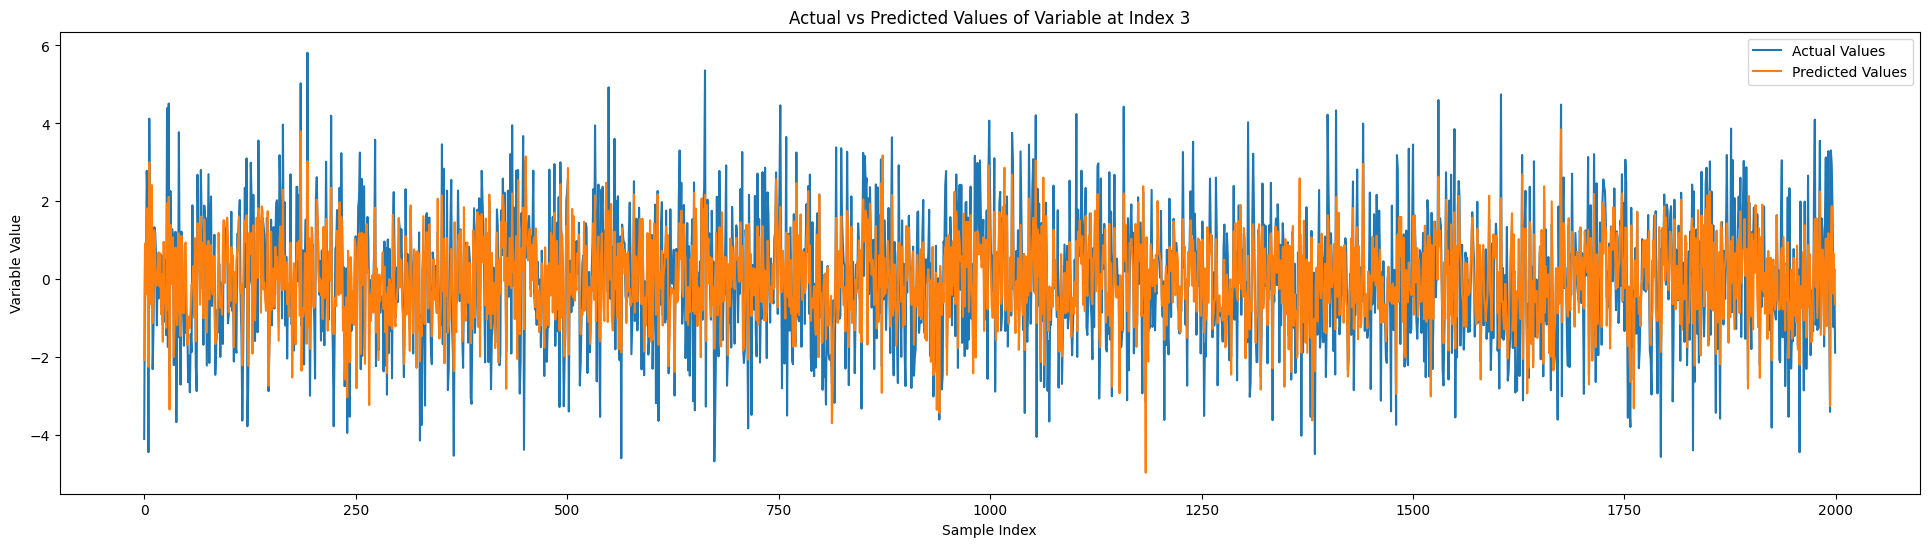

In [24]:
# Step 5: Forecast using the test dataset
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        predictions.append(out.cpu())
        actuals.append(data.y.cpu())

# Concatenate all predictions and actual values
predictions = torch.cat(predictions, dim=0)
actuals = torch.cat(actuals, dim=0)

# Calculate Mean Squared Error on the test set
mse = mean_squared_error(actuals.numpy(), predictions.numpy())
print(f'Test MSE: {mse:.4f}')

def smape(predictions, actuals):
    return 100 * torch.mean(2 * torch.abs(predictions - actuals) / (torch.abs(predictions) + torch.abs(actuals)))

smape_ = smape(predictions, actuals)
print(f'Test SMAPE: {smape_:.4f}')

# Optionally, plot the predictions vs actual values


plt.figure(figsize=(24, 6))
plt.plot(actuals.numpy(), label='Actual Values')
plt.plot(predictions.numpy(), label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Variable Value')
plt.title('Actual vs Predicted Values of Variable at Index 3')
plt.legend()
plt.show()